In [4]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

import numpy as np
import pandas as pd

from util import engineer_features

DATA_DIR = Path("./pistachio_1_data")
dyads_df = pd.read_csv(DATA_DIR / "all_dyads.csv")
sorted_dyads_df = dyads_df.sort_values(
    by="ActivityDateTime", key=lambda x: pd.to_datetime(x)
)
cleaned_dyads_dfs = engineer_features(sorted_dyads_df)
df = pd.concat(list(cleaned_dyads_dfs.values()), axis=1)

df_train = df[df["Arm_Sham"]]
df_test = df[~df["Arm_Sham"]]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/var/folders/gv/lj5cf4w14fqc6937ndlg7qb40000gr/T/ipykernel_7979/3275965156.py:12: DtypeWarning: Columns (95,124,125,126,127,128) have mixed types. Specify dtype option on import or set low_memory=False.
  dyads_df = pd.read_csv(DATA_DIR / "all_dyads.csv")
/Users/zhu.henian/projects/pistachio/util.py:150: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(df["ActivityDateTime"]) - pd.to_datetime(df["Therapy Start"])


In [ ]:
import matplotlib.pyplot as plt
from scipy import stats

weeks = (0, 15)
window = "30m"
feature = "hr_moving_avg_10m"

df = df[df["therapy_week"].between(weeks[0], weeks[1])]
df_train = df[df["Arm_Sham"]]
df_test = df[~df["Arm_Sham"]]

# Filter for cases with tantrum within 15m and therapy_week in 0-10
df_all = pd.concat([df_train, df_test])

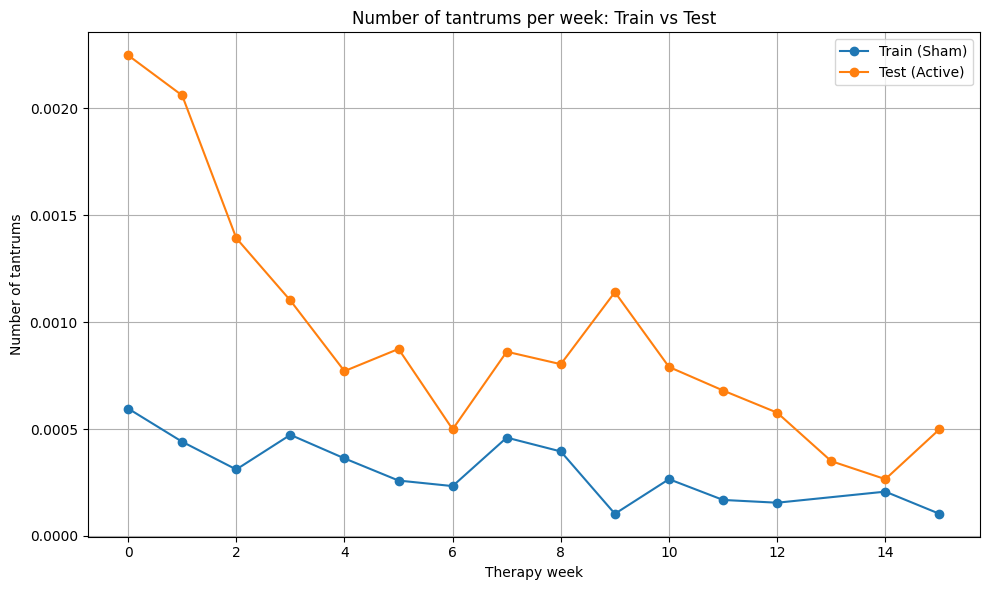

In [6]:
# Count number of tantrums per week for train and test sets
tantrums_train = df_train[df_train["tantrum_within_60m"]].groupby(
    "therapy_week"
).size() / len(df_train)
tantrums_test = df_test[df_test["tantrum_within_60m"]].groupby(
    "therapy_week"
).size() / len(df_train)

plt.figure(figsize=(10, 6))
plt.plot(tantrums_train.index, tantrums_train.values, marker="o", label="Train (Sham)")
plt.plot(tantrums_test.index, tantrums_test.values, marker="o", label="Test (Active)")
plt.xlabel("Therapy week")
plt.ylabel("Number of tantrums")
plt.title("Number of tantrums per week: Train vs Test")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

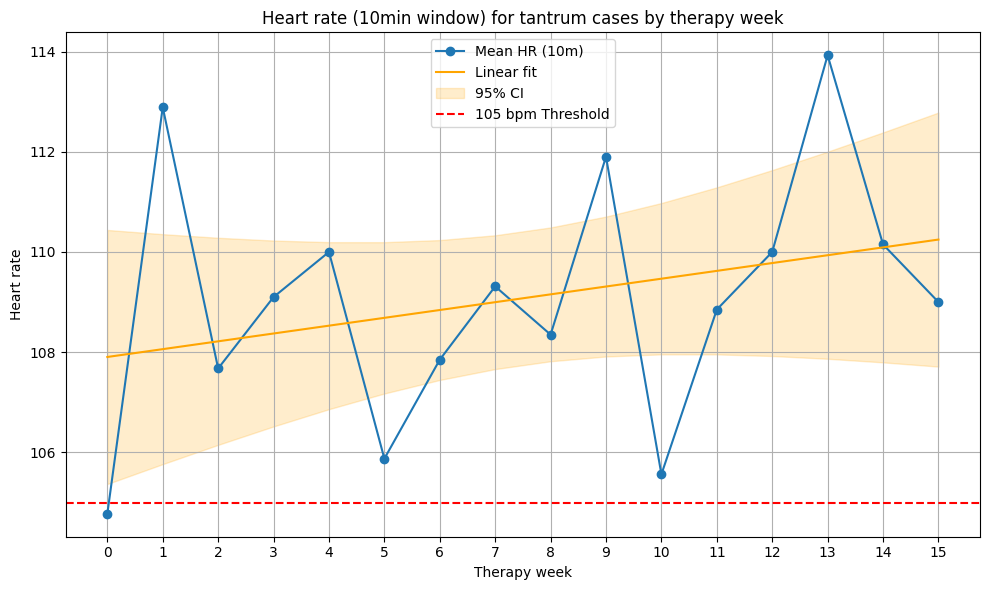

In [7]:
df_cases = df_all[df_all["tantrum_within_60m"]]
means = []
weeks_range = range(weeks[0], weeks[1] + 1)
for week in weeks_range:
    week_data = df_cases[df_cases["therapy_week"] == week]
    means.append(week_data[feature].median())

# Prepare data for regression
x = np.array(list(weeks_range))
y = np.array(means)

# Fit linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
y_pred = intercept + slope * x

# Compute 95% CI for regression line
n = len(x)
t_val = stats.t.ppf(0.975, n - 2)
y_fit = intercept + slope * x
residuals = y - y_fit
s_err = np.sqrt(np.sum(residuals**2) / (n - 2))
conf = (
    t_val
    * s_err
    * np.sqrt(1 / n + (x - np.mean(x)) ** 2 / np.sum((x - np.mean(x)) ** 2))
)


plt.figure(figsize=(10, 6))

# Plot regression line and CI
plt.plot(weeks_range, means, marker="o", label="Mean HR (10m)")
plt.plot(x, y_pred, color="orange", label="Linear fit")
plt.fill_between(
    x, y_pred - conf, y_pred + conf, color="orange", alpha=0.2, label="95% CI"
)
plt.axhline(105, color="red", linestyle="--", label="105 bpm Threshold")
# plt.axhline(129, color="red", linestyle="--")
plt.legend()
plt.xlabel("Therapy week")
plt.ylabel("Heart rate")
plt.title("Heart rate (10min window) for tantrum cases by therapy week")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(weeks_range)
plt.show()